### Добавляем необходимые библиотеки

In [18]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Грузим датасет

In [19]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('/Users/aleksandrandreev/data_analyse/data_analysis_hse/data/dataset.csv')
data_train, data_test = train_test_split(data, test_size=0.2)

In [20]:
data.sample(5)

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
2724332,2724332,p,5.13,b,s,g,f,NaN,NaN,k,...,NaN,s,w,NaN,NaN,t,z,NaN,d,w
2851151,2851151,p,1.51,b,h,n,f,a,NaN,n,...,NaN,t,n,NaN,NaN,f,f,NaN,d,s
1760430,1760430,p,2.49,o,NaN,g,f,f,f,f,...,NaN,g,g,NaN,NaN,f,f,NaN,d,u
2456929,2456929,e,0.88,f,g,e,t,a,NaN,p,...,NaN,NaN,n,NaN,NaN,f,f,NaN,h,u
1034387,1034387,p,6.92,s,t,r,t,d,NaN,w,...,NaN,t,r,NaN,NaN,f,f,NaN,d,a


Процент пропусков в каждой из колонок

In [21]:
# def na_percentage(feature):
# 	cnt_nulls = sum(data_train[feature].isna())
# 	n_rows = data_train.shape[0]
# 	percentage = round(cnt_nulls / n_rows * 100)
# 	print(f'{feature}: {cnt_nulls} / {n_rows} = {percentage}%')
# 	print(data_train[feature].dtype)

# for col in data_train.columns:
# 	na_percentage(col)

### Preprocessing

In [22]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.sparse import csr_matrix, hstack

class DataPreprocessor(TransformerMixin, BaseEstimator):
	def __init__(self, needed_columns=None, valid_values=None, target_column=None):
		self.scaler = StandardScaler()
		self.ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
		self.needed_columns = needed_columns
		self.valid_values = valid_values
		self.categorical_columns = []
		self.continuous_columns = []
		self.target_column = target_column

	def fit(self, X):
		data = X.copy()

		if self.needed_columns is not None:
			data = data[self.needed_columns]

		if self.target_column in data.columns:
			data = data.drop(columns=[self.target_column])

		self.continuous_columns = [col for col in data.columns if data[col].dtype in ('float64', 'int64') and col != self.target_column]
		self.categorical_columns = [col for col in data.columns if data[col].dtype not in ('float64', 'int64') and col != self.target_column]

		if self.valid_values is not None:
			for col in self.categorical_columns:
				data = data[data[col].isin(self.valid_values[col])]

		self.ohe.fit(data[self.categorical_columns])
		self.scaler.fit(data[self.continuous_columns])

		return self

	def transform(self, X):
		data = X.copy()

		targetExists = self.target_column in data.columns

		if self.needed_columns is not None:
			# Проверим, чтобы все нужные колонки были в датафрейме
			missing_cols = set(self.needed_columns) - set(data.columns)
			if missing_cols:
				raise ValueError(f"Missing columns in input data: {missing_cols}")
			data = data[self.needed_columns + [self.target_column] if targetExists else self.needed_columns]

		# Заполнение пропусков для категориальных переменных
		for col in self.categorical_columns:
			if col in data.columns:
				mode_val = data[col].mode(dropna=True)
				if not mode_val.empty:
					data.loc[:, col] = data[col].fillna(mode_val[0])
				else:
					data.loc[:, col] = data[col].fillna("unknown")

		# Заполнение пропусков для числовых переменных
		for col in self.continuous_columns:
			if col in data.columns:
				data.loc[:, col] = data[col].fillna(data[col].median())

		if self.valid_values is not None:
			for col in self.categorical_columns:
				if col in data.columns:
					data = data[data[col].isin(self.valid_values[col])]

		# Если после фильтрации ничего не осталось — отрабатываем это
		if data.shape[0] == 0:
			raise ValueError("No samples left after filtering by valid_values. Check your input data.")

		if targetExists:
			y = data[self.target_column]
			data = data.drop(columns=[self.target_column])

		# Проверяем, что все continuous_columns есть в data
		missing_cont_cols = set(self.continuous_columns) - set(data.columns)
		if missing_cont_cols:
			raise ValueError(f"Missing continuous columns in input data: {missing_cont_cols}")

		# Проверяем, что все categorical_columns есть в data
		missing_cat_cols = set(self.categorical_columns) - set(data.columns)
		if missing_cat_cols:
			raise ValueError(f"Missing categorical columns in input data: {missing_cat_cols}")

		# Если всё ок — трансформируем
		data1 = self.scaler.transform(data[self.continuous_columns])
		data2 = self.ohe.transform(data[self.categorical_columns])

		X_transformed = hstack([csr_matrix(data1), data2])

		return (X_transformed, y) if targetExists else X_transformed

### Predictions

In [23]:
import joblib


In [24]:
needed_columns = [
 	'cap-shape',
 	'cap-surface',
 	'cap-color',
 	'does-bruise-or-bleed',
 	'gill-attachment',
 	'gill-color',
 	'stem-color',
 	'has-ring',
 	'ring-type',
 	'habitat',
 	'season',
    'cap-diameter',
	'stem-height',
	'stem-width'
]

valid_values = {
	'class': ['p', 'e'],
	'cap-shape': ['b', 'c', 'x', 'f', 'k', 's'],
	'cap-surface': ['f', 'g', 'y', 's'],
	'cap-color': ['n', 'b', 'c', 'g', 'r', 'p', 'u', 'e', 'w', 'y'],
	'does-bruise-or-bleed': ['f', 't'],
	'gill-attachment': ['a', 'd', 'f', 'n'],
	'gill-color': ['k', 'n', 'b', 'h', 'g', 'r', 'o', 'p', 'u', 'e', 'w', 'y'],
	'stem-color': ['n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y'],
	'has-ring': ['f', 't'],
	'ring-type': ['c', 'e', 'f', 'l', 'n', 'p', 's', 'z'],
	'habitat': ['g', 'l', 'm', 'p', 'u', 'w', 'd'],
	'season': ['a', 'w', 'u', 's']
}

preprocessor = DataPreprocessor(
	needed_columns=needed_columns,
	valid_values=valid_values,
	target_column='class'
)

X_train, y_train = preprocessor.fit_transform(data_train)

In [25]:
X_test, y_test = preprocessor.transform(data_test)

In [26]:

from catboost import CatBoostClassifier

classifier = CatBoostClassifier()
classifier.fit(X_train, y_train)

Learning rate set to 0.121464
0:	learn: 0.6115861	total: 18.7ms	remaining: 18.7s
1:	learn: 0.5101170	total: 35.2ms	remaining: 17.6s
2:	learn: 0.4503310	total: 50.5ms	remaining: 16.8s
3:	learn: 0.4134654	total: 65.7ms	remaining: 16.4s
4:	learn: 0.3548475	total: 82.1ms	remaining: 16.3s
5:	learn: 0.3297398	total: 97.1ms	remaining: 16.1s
6:	learn: 0.3113939	total: 113ms	remaining: 16s
7:	learn: 0.2887409	total: 128ms	remaining: 15.9s
8:	learn: 0.2660258	total: 144ms	remaining: 15.9s
9:	learn: 0.2517006	total: 159ms	remaining: 15.7s
10:	learn: 0.2364606	total: 174ms	remaining: 15.7s
11:	learn: 0.2271968	total: 192ms	remaining: 15.8s
12:	learn: 0.2081216	total: 208ms	remaining: 15.8s
13:	learn: 0.1968928	total: 223ms	remaining: 15.7s
14:	learn: 0.1856531	total: 242ms	remaining: 15.9s
15:	learn: 0.1735202	total: 258ms	remaining: 15.9s
16:	learn: 0.1651816	total: 274ms	remaining: 15.8s
17:	learn: 0.1556707	total: 290ms	remaining: 15.8s
18:	learn: 0.1469359	total: 306ms	remaining: 15.8s
19:	lea

In [27]:
y_pred = classifier.predict(X_test)
y_score = classifier.predict_proba(X_test)[:, 1]

In [28]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

print(f'accuracy: {accuracy_score(y_test, y_pred)}')
print(f"f1 score: {f1_score(y_test, y_pred, average='binary', pos_label='p')}")
print(f'roc_auc: {roc_auc_score(y_test, y_score)}')

accuracy: 0.9848419121748075
f1 score: 0.9853517145560599
roc_auc: 0.9956432556460596


# Графики

In [29]:
remove_cols = [
	'id',
	'stem-root',
	'stem-surface',
	'veil-type',
	'veil-color',
	'spore-print-color',
	'gill-spacing'
]

data = data.drop(columns=remove_cols)

In [30]:
categorical_columns = [key for key in data.keys() if data[key].dtype not in ('float64', 'int64')]
categorical_columns

['class',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-color',
 'stem-color',
 'has-ring',
 'ring-type',
 'habitat',
 'season']

In [31]:
valid_values = {
	'class': ['p', 'e'],
	'cap-shape': ['b', 'c', 'x', 'f', 'k', 's'],
	'cap-surface': ['f', 'g', 'y', 's'],
	'cap-color': ['n', 'b', 'c', 'g', 'r', 'p', 'u', 'e', 'w', 'y'],
	'does-bruise-or-bleed': ['f', 't'],
	'gill-attachment': ['a', 'd', 'f', 'n'],
	'gill-color': ['k', 'n', 'b', 'h', 'g', 'r', 'o', 'p', 'u', 'e', 'w', 'y'],
	'stem-color': ['n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y'],
	'has-ring': ['f', 't'],
	'ring-type': ['c', 'e', 'f', 'l', 'n', 'p', 's', 'z'],
	'habitat': ['g', 'l', 'm', 'p', 'u', 'w', 'd'],
	'season': ['a', 'w', 'u', 's']
}

for col in categorical_columns:
	data[col] = data[col].fillna(data[col].mode()[0])
	data = data[data[col].isin(valid_values[col])]

data.shape

(403832, 15)

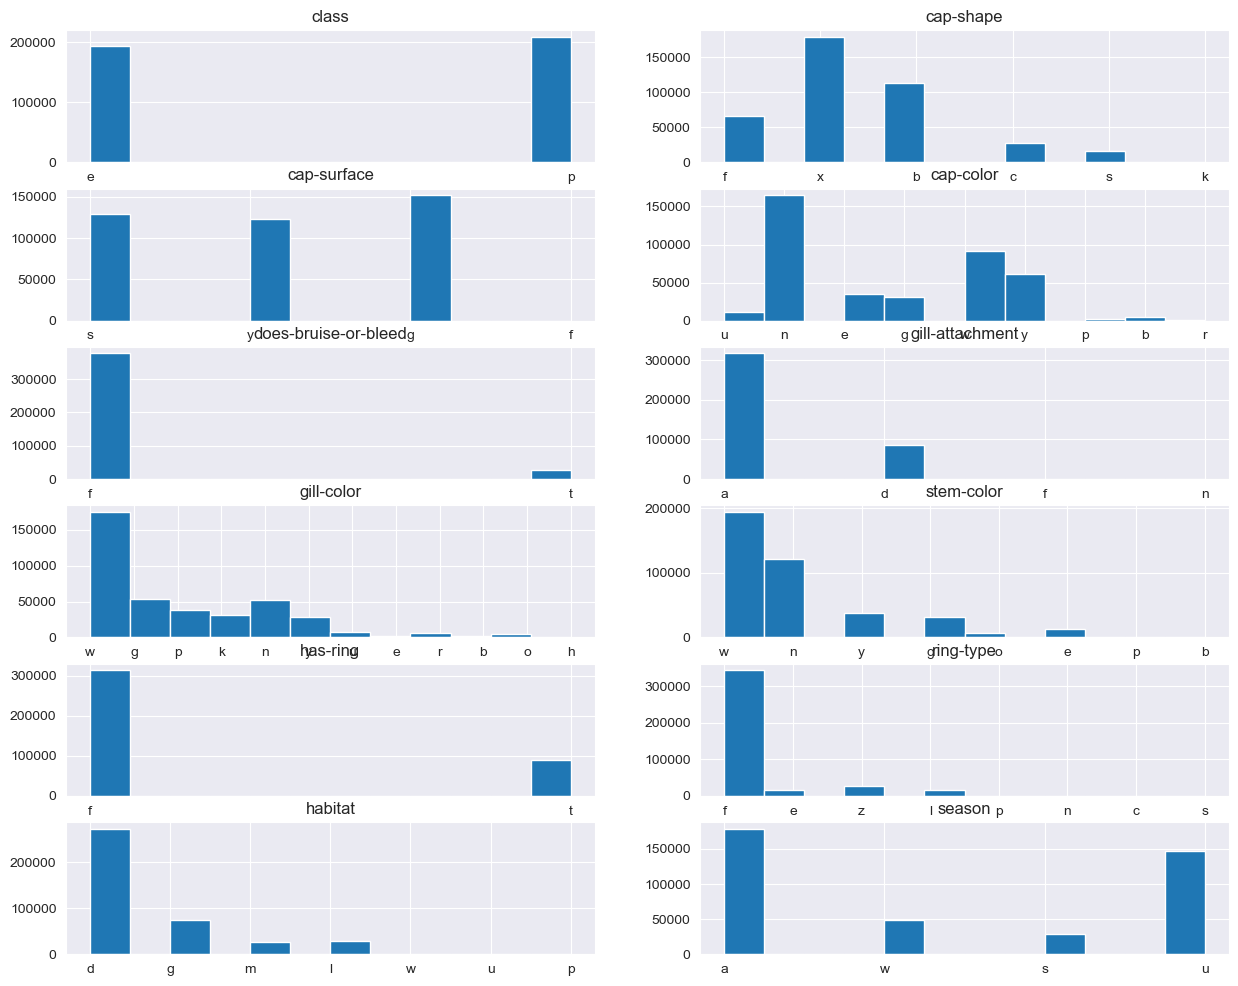

In [32]:
ncols = 2
nrows = (len(categorical_columns) + ncols - 1) // ncols
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 6*ncols))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
	try:
		axes[i].hist(data[col], bins=12)
		axes[i].set_title(col)
	except:
		print(col)

plt.show()

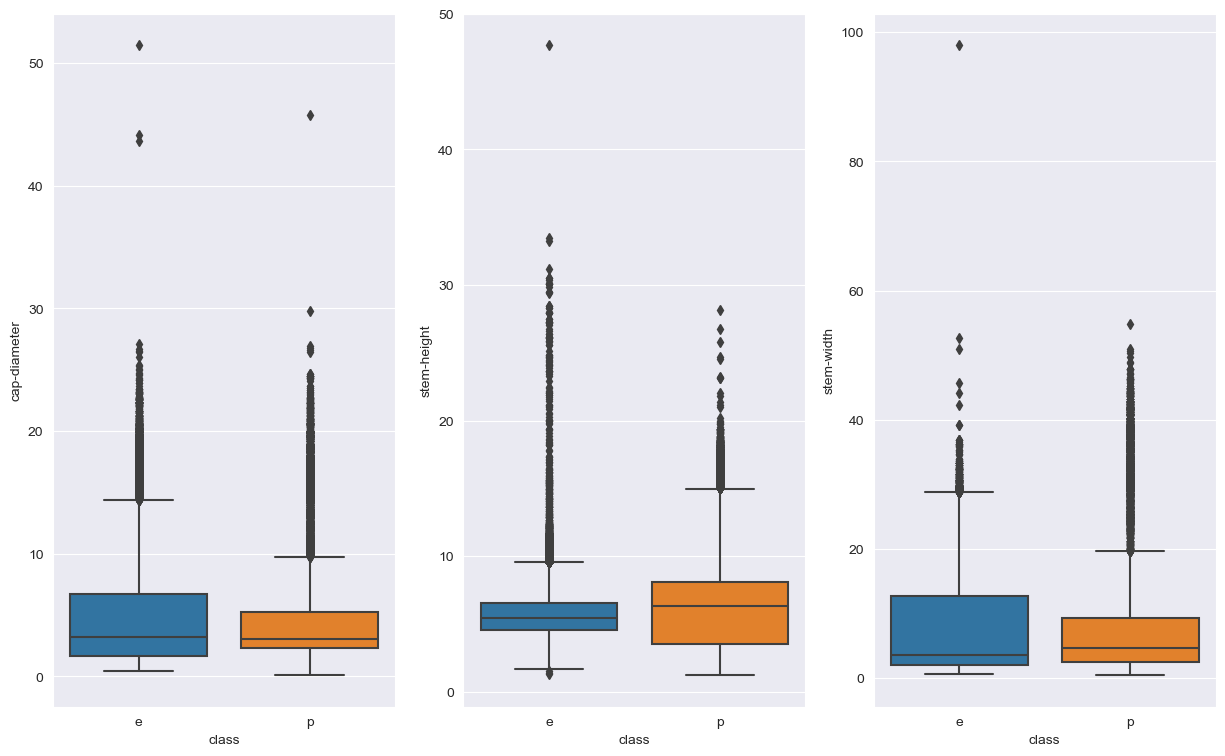

In [33]:
continuous_columns = [key for key in data.keys() if data[key].dtype in ('int64', 'float64')]

ncols = 3
nrows = (len(continuous_columns) + ncols - 1) // ncols
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 3*ncols))
axes = axes.flatten()

for i, col in enumerate(continuous_columns):
	sns.boxplot(data=data, x='class', y=col, ax=axes[i])

plt.show()

In [35]:

classifier.save_model("classifier.cbm")

joblib.dump(preprocessor, "/Users/aleksandrandreev/data_analyse/data_analysis_hse/my_preprocessor.pkl")

['/Users/aleksandrandreev/data_analyse/data_analysis_hse/my_preprocessor.pkl']